In [1]:
%pylab --no-import-all
%matplotlib inline

pylab.rcParams['figure.figsize'] = (6,6)
# print pylab.rcParams.keys()
pylab.rcParams['image.cmap'] = 'gray'

import scipy.io as sio

data_raw = sio.loadmat('pendigits.mat')

xtrain, ytrain = data_raw['xtrain'].T, data_raw['ytrain'][0]
xtest, ytest = data_raw['xtest'].T, data_raw['ytest'][0]


Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


## Show some examples

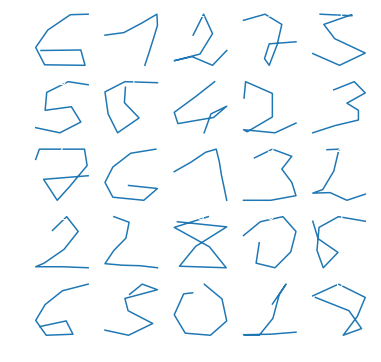

In [2]:
fig, ax = plt.subplots(5,5)

for idx in xrange(5):
  for jdx in xrange(5):
    num = np.random.randint(0, len(xtrain))
    x = xtrain[num][::2]
    y = xtrain[num][1::2]
    ax[idx][jdx].plot(x, y)
    ax[idx][jdx].grid('off')
    ax[idx][jdx].set_axis_off()
    ax[idx][jdx].set_title(str(ytrain[num]), color='w', y=0.8)
plt.show()

## "Hardness"

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures

linear = LogisticRegression()
linear.fit(xtrain, ytrain)
print "Linear Score:", linear.score(xtrain, ytrain)

# polynomial = make_pipeline(PolynomialFeatures(degree=2), LogisticRegression())
xtrain_poly = PolynomialFeatures(degree=2).fit_transform(xtrain)
polynomial = LogisticRegression()

polynomial = LogisticRegression()
polynomial.fit(xtrain_poly, ytrain)
print "Polynomial Score:", polynomial.score(xtrain_poly, ytrain)


Linear Score: 0.947157726181
Polynomial Score: 0.999866559915


In [4]:
y_linear = linear.predict(xtrain)
y_poly = polynomial.predict(xtrain_poly)

y_classifier = -np.ones(ytrain.shape)
y_classifier[y_linear != ytrain] = 1

print np.sum(y_classifier)

-6702.0


### What examples cannot be classified using a linear?

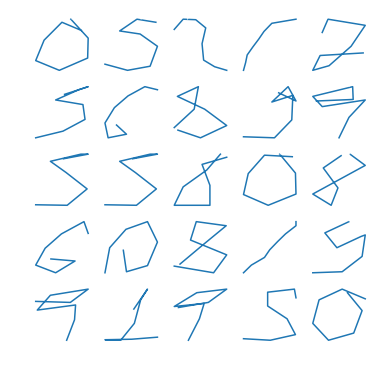

In [5]:
x_lin_wrong = xtrain[y_linear != ytrain]
y_lin_wrong = y_linear[y_linear != ytrain]
fig, ax = plt.subplots(5,5)
for idx in xrange(5):
  for jdx in xrange(5):
    num = np.random.randint(0, len(x_lin_wrong))
    x = x_lin_wrong[num][::2]
    y = x_lin_wrong[num][1::2]
    ax[idx][jdx].plot(x, y)
    ax[idx][jdx].grid('off')
    ax[idx][jdx].set_axis_off()
    ax[idx][jdx].set_title('T:' + str(ytrain[y_linear != ytrain][num]) + 
                           '/P:' + str(y_poly[y_linear != ytrain][num]) + 
                           '/L:' + str(y_linear[y_linear != ytrain][num]), color='w', y=0.9)
plt.show()

### Distance to decision boundary

In [6]:
decision_distance = linear.decision_function(xtrain)
## Distance to the second candidate
# dec = np.zeros(decision_distance.shape[0])
dec = []
for idx, x in enumerate(decision_distance):
  # print idx, x
  if sum(x > 0) == 1:
    # Only one true
    # dec.append(1.)
    pass
  else:
    x.sort()
    dec.append(np.abs((x[-1] - x[-2]) / (x[-1]+x[-2])))
# n, bins, patches = plt.hist(decision_distance, 50, normed=1, facecolor='green', alpha=0.75)

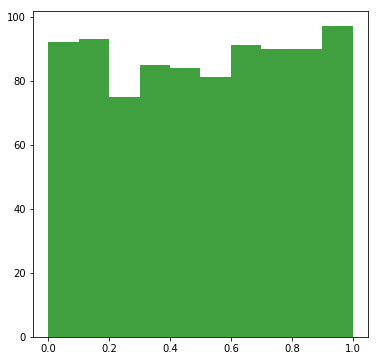

In [7]:
n, bins, patches = plt.hist(dec, 10, facecolor='green', alpha=0.75)

### Distance to decision boundary -- Attempt # 2
Let's use a synthetic dataset

In [2]:
%pylab --no-import-all

x_axis = np.arange(-10, 10, 1e-2)
xx_axis = x_axis*x_axis
xxx_axis = xx_axis*x_axis

y_decision = .1 - .9*x_axis + .3*xx_axis - .7*xxx_axis
y_min, y_max = y_decision.min(), y_decision.max()
y_row = np.linspace(y_min, y_max, len(y_decision))

# print y_min, y_max
# print y_row.shape
y_rows = np.tile(y_row, (len(x_axis),1)).T
y_labels = np.ones(y_rows.shape)
y_labels[y_rows < y_decision] = -1
# print y_labels
# print y_labels.shape

samplex = np.random.randint(0, len(x_axis), int(0.3*len(x_axis)))
sampley = np.random.randint(0, len(y_decision), int(0.3*len(y_decision)))
samplelabel = y_labels[sampley, samplex]
samplex, sampley = x_axis[samplex], y_row[sampley]
samplefeatures = np.vstack((samplex, sampley)).T
print samplelabel.shape, samplefeatures.shape
# sampley = y_decision[sampley]
## Test:
testx = np.random.randint(0, len(x_axis), int(0.3*len(x_axis)))
testy = np.random.randint(0, len(y_decision), int(0.3*len(y_decision)))
testlabel = y_labels[testy, testx]
testx, testy = x_axis[testx], y_row[testy]
testfeatures = np.vstack((testx, testy)).T
print testlabel.shape, testfeatures.shape


Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
(600,) (600, 2)
(600,) (600, 2)


In [9]:
## Training the linear
from sklearn.linear_model import LogisticRegression
linear = LogisticRegression()

linear.fit(samplefeatures, samplelabel)
print "Training score:", linear.score(samplefeatures, samplelabel)
print "Random re-sample score:", linear.score(testfeatures, testlabel)


a = -linear.coef_[0][0] / linear.coef_[0][1]
b = -linear.intercept_[0] / linear.coef_[0][1]
y_decision_prime = a*x_axis + b

y_labels_prime = np.ones(y_rows.shape)
y_labels_prime[y_rows < y_decision_prime] = -1

## use samplex, sampley to find the hard problems
samplelabel_prime = linear.predict(samplefeatures)
wrong = samplelabel_prime != samplelabel
samplex_prime, sampley_prime = samplex[wrong], sampley[wrong]
samplefeatures_prime = samplefeatures[wrong]

# print linear.decision_function(samplefeatures_prime)

hard_bias = np.max(np.abs(sampley_prime - a*samplex_prime - b))
# print hard_bias

y_decision_hard_up = y_decision_prime + hard_bias
y_decision_hard_down = y_decision_prime - hard_bias

y_labels_hard = -np.ones(y_rows.shape)
y_labels_hard[np.logical_and(y_rows < y_decision_hard_up, y_rows > y_decision_hard_down)] = 1

print linear.coef_, linear.intercept_


Training score: 0.941666666667
Random re-sample score: 0.936666666667
[[ 0.82019061  0.0174472 ]] [-0.19499401]


Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


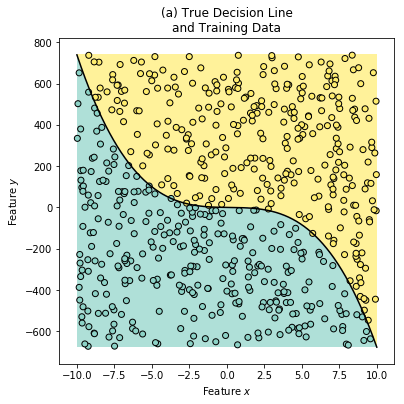

In [10]:
%pylab --no-import-all
%matplotlib inline

pylab.rcParams['figure.figsize'] = (6,6)
# print pylab.rcParams.keys()
pylab.rcParams['image.cmap'] = 'gray'

cmap = 'Set3'
textcol = 'k'

fig, ax = plt.subplots(1,1, sharey=True)

ax.imshow(
  y_labels, 
  interpolation='nearest', 
  aspect='auto', 
  origin='lower', 
  extent=[x_axis.min(), x_axis.max(), y_decision.min(), y_decision.max()], 
  cmap=cmap,  
  alpha=.7,)
ax.plot(x_axis, y_decision, color='k')
ax.scatter(samplex, sampley, c=samplelabel, cmap=cmap, edgecolors='k')
# ax[0].set_axis_off()
ax.set_ylabel('Feature $y$')
ax.set_xlabel('Feature $x$')
ax.set_title('(a) True Decision Line\nand Training Data', color=textcol)

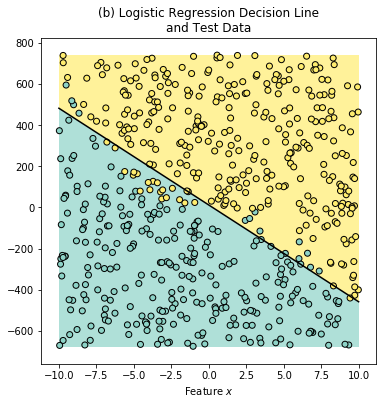

In [11]:
fig, ax = plt.subplots(1,1, sharey=True)

ax.imshow(
  y_labels_prime, 
  interpolation='nearest', 
  aspect='auto', 
  origin='lower', 
  extent=[x_axis.min(), x_axis.max(), y_decision.min(), y_decision.max()], 
  cmap=cmap,  
  alpha=.7,)
ax.plot(x_axis, y_decision_prime, color='k')
ax.scatter(testx, testy, c=testlabel, cmap=cmap, edgecolors='k')
# ax[1].set_axis_off()
# ax[1].set_ylabel('Feature $y$')
ax.set_xlabel('Feature $x$')
ax.set_title('(b) Logistic Regression Decision Line\nand Test Data', color=textcol)

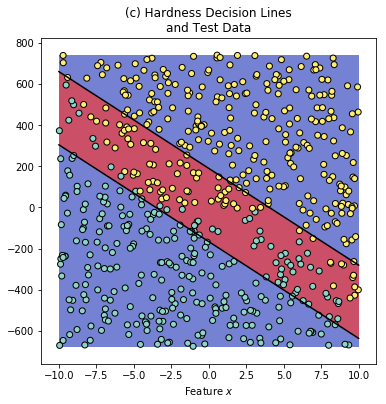

In [12]:
fig, ax = plt.subplots(1,1, sharey=True)

ax.imshow(
  y_labels_hard, 
  interpolation='nearest', 
  aspect='auto', 
  origin='lower', 
  extent=[x_axis.min(), x_axis.max(), y_decision.min(), y_decision.max()], 
  cmap='coolwarm',  
  alpha=.7,)
# ax[2].plot(x_axis, y_decision_prime, color='k')
ax.plot(x_axis, y_decision_hard_up, color='k')
ax.plot(x_axis, y_decision_hard_down, color='k')
ax.scatter(testx, testy, c=testlabel, cmap=cmap, edgecolors='k')
# ax[2].set_axis_off()
# ax[2].set_ylabel('Feature $y$')
ax.set_xlabel('Feature $x$')
ax.set_title('(c) Hardness Decision Lines\nand Test Data', color=textcol)

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


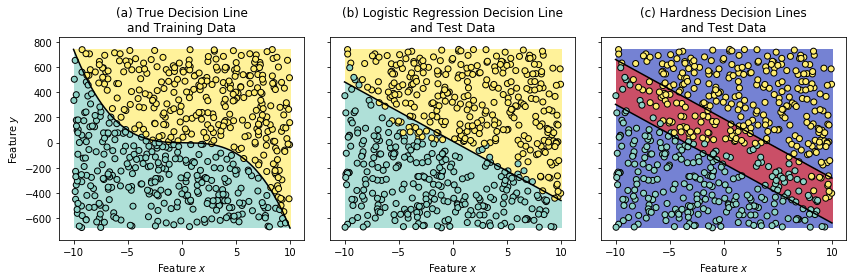

In [13]:
%pylab --no-import-all
%matplotlib inline

pylab.rcParams['figure.figsize'] = (12,4)
# print pylab.rcParams.keys()
pylab.rcParams['image.cmap'] = 'gray'

cmap = 'Set3'
textcol = 'k'

fig, ax = plt.subplots(1,3, sharey=True)

ax[0].imshow(
  y_labels, 
  interpolation='nearest', 
  aspect='auto', 
  origin='lower', 
  extent=[x_axis.min(), x_axis.max(), y_decision.min(), y_decision.max()], 
  cmap=cmap,  
  alpha=.7,)
ax[0].plot(x_axis, y_decision, color='k')
ax[0].scatter(samplex, sampley, c=samplelabel, cmap=cmap, edgecolors='k')
# ax[0].set_axis_off()
ax[0].set_ylabel('Feature $y$')
ax[0].set_xlabel('Feature $x$')
ax[0].set_title('(a) True Decision Line\nand Training Data', color=textcol)

ax[1].imshow(
  y_labels_prime, 
  interpolation='nearest', 
  aspect='auto', 
  origin='lower', 
  extent=[x_axis.min(), x_axis.max(), y_decision.min(), y_decision.max()], 
  cmap=cmap,  
  alpha=.7,)
ax[1].plot(x_axis, y_decision_prime, color='k')
ax[1].scatter(testx, testy, c=testlabel, cmap=cmap, edgecolors='k')
# ax[1].set_axis_off()
# ax[1].set_ylabel('Feature $y$')
ax[1].set_xlabel('Feature $x$')
ax[1].set_title('(b) Logistic Regression Decision Line\nand Test Data', color=textcol)

ax[2].imshow(
  y_labels_hard, 
  interpolation='nearest', 
  aspect='auto', 
  origin='lower', 
  extent=[x_axis.min(), x_axis.max(), y_decision.min(), y_decision.max()], 
  cmap='coolwarm',  
  alpha=.7,)
# ax[2].plot(x_axis, y_decision_prime, color='k')
ax[2].plot(x_axis, y_decision_hard_up, color='k')
ax[2].plot(x_axis, y_decision_hard_down, color='k')
ax[2].scatter(testx, testy, c=testlabel, cmap=cmap, edgecolors='k')
# ax[2].set_axis_off()
# ax[2].set_ylabel('Feature $y$')
ax[2].set_xlabel('Feature $x$')
ax[2].set_title('(c) Hardness Decision Lines\nand Test Data', color=textcol)
fig.tight_layout()

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


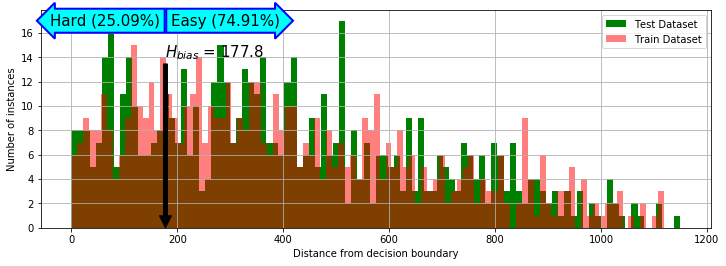

In [14]:
%pylab --no-import-all
%matplotlib inline

pylab.rcParams['figure.figsize'] = (12,4)
# print pylab.rcParams.keys()
pylab.rcParams['image.cmap'] = 'gray'


## Distance to the decision line
## use samplex, sampley to find the hard problems
# samplelabel_prime = linear.predict(samplefeatures)
# wrong = samplelabel_prime != samplelabel
# samplex_prime, sampley_prime = samplex[wrong], sampley[wrong]
# samplefeatures_prime = samplefeatures[wrong]

# print linear.decision_function(samplefeatures_prime)

distance = np.abs(testy - a*testx - b)
n1, bins1, patches1 = plt.hist(distance, 100, facecolor='green', label="Test Dataset")
n2, bins2, patches1 = plt.hist(np.abs(sampley - a*samplex - b), 100, facecolor='red', alpha=0.5, label="Train Dataset")
# plt.plot([hard_bias, hard_bias], [0,20], '--k', linewidth=5, label="Hardness Threshold = %.1f"%hard_bias)
plt.legend()
# plt.yticks([])
plt.grid()
plt.xlabel("Distance from decision boundary")
plt.ylabel("Number of instances")

hard = np.sum(y_labels_hard == 1) / np.float(len(y_labels_hard)*len(y_labels_hard[0]))
easy = 1 - hard

# plt.text(0, 17.5, '%.1f%%'%(hard*100), fontsize=16)

bbox_props = dict(boxstyle="larrow,pad=0.3", fc="cyan", ec="b", lw=2)
plt.text(hard_bias-10, 17, "Hard (%.2f%%)"%(hard*100), ha="right", va="center", rotation=0,
            size=15,
            bbox=bbox_props)

bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="cyan", ec="b", lw=2)
plt.text(hard_bias+10, 17, "Easy (%.2f%%)"%(easy*100), ha="left", va="center", rotation=0,
            size=15,
            bbox=bbox_props)


plt.annotate("$H_{bias}$ = %.1f"%hard_bias, xy=(hard_bias, 0), xytext=(hard_bias, 14),
            arrowprops=dict(facecolor='black', shrink=0.0),
            ha='left', size=15
            )

## Everything + Chooser Function

In [33]:
%pylab --no-import-all
%matplotlib inline

pylab.rcParams['figure.figsize'] = (8,4)
# print pylab.rcParams.keys()
pylab.rcParams['image.cmap'] = 'gray'

normalize = True

x_axis = np.arange(-10, 10, 1e-2)
xx_axis = x_axis*x_axis
xxx_axis = xx_axis*x_axis

y_decision = .1 - .9*x_axis + .3*xx_axis - .7*xxx_axis
# y_decision = xxx_axis + 2*xx_axis - 5*x_axis - 6

if normalize:
  x_axis /= x_axis.max() - x_axis.min()
  y_decision /= y_decision.max() - y_decision.min()

y_min, y_max = y_decision.min(), y_decision.max()
y_row = np.linspace(y_min, y_max, len(y_decision))

# print y_min, y_max
# print y_row.shape
y_rows = np.tile(y_row, (len(x_axis), 1)).T
y_labels = np.ones(y_rows.shape)
y_labels[y_rows < y_decision] = -1
# print y_labels
# print y_labels.shape

samplex = np.random.randint(0, len(x_axis), int(0.6*len(x_axis)))
sampley = np.random.randint(0, len(y_decision), int(0.6*len(y_decision)))
samplelabel = y_labels[sampley, samplex]
samplex, sampley = x_axis[samplex], y_row[sampley]
samplefeatures = np.vstack((samplex, sampley)).T
print samplelabel.shape, samplefeatures.shape
# sampley = y_decision[sampley]
## Test:
testx = np.random.randint(0, len(x_axis), int(0.2*len(x_axis)))
testy = np.random.randint(0, len(y_decision), int(0.2*len(y_decision)))
testlabel = y_labels[testy, testx]
testx, testy = x_axis[testx], y_row[testy]
testfeatures = np.vstack((testx, testy)).T
print testlabel.shape, testfeatures.shape

# fig, ax = plt.subplots(1,2, sharey=True)
# ax[0].scatter(samplefeatures[:,0], samplefeatures[:,1], c=samplelabel, cmap=cmap, edgecolors='k')
# ax[1].scatter(testfeatures[:,0], testfeatures[:,1], c=testlabel, cmap=cmap, edgecolors='k')

XX, YY = np.meshgrid(x_axis, y_row)
c_ravel = np.c_[XX.ravel(), YY.ravel()]


Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib
(1200,) (1200, 2)
(400,) (400, 2)


"Easy" Classifier Accuracy
	Train:	93.17%
	Test:	95.25%
"Hard" Classifier Accuracy
	Train:	99.67%
	Test:	98.00%


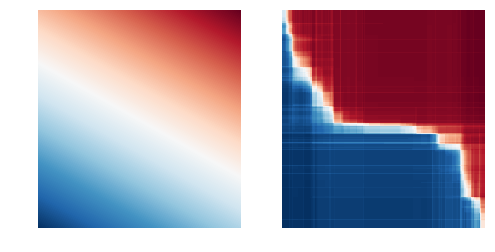

In [195]:
from sklearn.svm import LinearSVC # For chooser
from sklearn.linear_model import LogisticRegression # For easy
from sklearn.svm import SVC # For hard
from sklearn.linear_model import SGDClassifier # For hard
from sklearn.pipeline import Pipeline # For hard
from sklearn.neural_network import MLPClassifier # For hard
from sklearn.neighbors import KNeighborsClassifier # For hard
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

easy = LogisticRegression()
# hard = SVC(kernel='rbf')
# hard = SGDClassifier(loss="hinge", penalty="l2")
# hard = MLPClassifier(hidden_layer_sizes = (36, 36, 18), activation='tanh')
# hard = KNeighborsClassifier(5)
# hard = AdaBoostClassifier()
hard = RandomForestClassifier(max_depth=5, n_estimators=100, max_features=1)

# chooser.fit(samplefeatures, y_labels_hard)
X_train, y_train = samplefeatures, samplelabel
X_test, y_test = testfeatures, testlabel

fig, ax = plt.subplots(1,2)

## Train the easy and the hard classifiers
easy.fit(X_train, y_train)
print '"Easy" Classifier Accuracy'
print '\tTrain:\t{:.2%}'.format(easy.score(X_train, y_train))
print '\tTest:\t{:.2%}'.format(easy.score(X_test, y_test))
Zeasy = easy.decision_function(c_ravel).reshape(XX.shape)
ax[0].pcolormesh(XX, YY, -Zeasy, cmap=plt.cm.RdBu)
ax[0].set_axis_off()

hard.fit(X_train, y_train)
print '"Hard" Classifier Accuracy'
print '\tTrain:\t{:.2%}'.format(hard.score(X_train, y_train))
print '\tTest:\t{:.2%}'.format(hard.score(X_test, y_test))
if hasattr(hard, "decision_function"):
  Zhard = hard.decision_function(c_ravel).reshape(XX.shape)
else:
  Zhard = hard.predict_proba(c_ravel)[:, 1].reshape(XX.shape)
ax[1].pcolormesh(XX, YY, -Zhard, cmap=plt.cm.RdBu)
ax[1].set_axis_off()

"Chooser" Accuracy
	Train:	98.92%


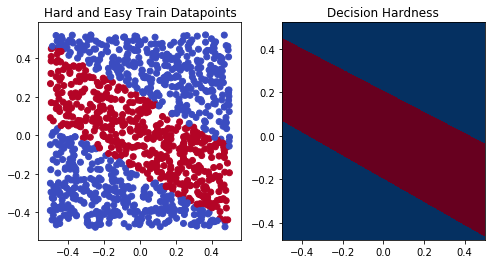

In [161]:
pylab.rcParams['figure.figsize'] = (8,4)

y_pseudo = -np.ones(y_train.shape)
y_prime_easy = easy.predict(X_train)
wrong = y_prime_easy != y_train

a = -easy.coef_[0][0] / easy.coef_[0][1]
b = -easy.intercept_[0] / easy.coef_[0][1]
# x_ax = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), len(X_train[:, 0]))
y_prime_easy_regr = X_train[:, 0]*a + b

H_bias = np.max(np.abs(X_train[:, 1][wrong] - y_prime_easy_regr[wrong]))
# y_prime_easy_regr = (np.dot(X_train, easy.coef_.T) + easy.intercept_).T[0]

y_decision_hard_up = y_prime_easy_regr + H_bias
y_decision_hard_down = y_prime_easy_regr - H_bias

y_pseudo = -np.ones(y_train.shape)
hard = np.logical_and(X_train[:,1] < y_decision_hard_up, X_train[:,1]  > y_decision_hard_down)
y_pseudo[hard] = 1
y_pseudo_1 = -np.ones(y_train.shape)
y_pseudo_1[X_train[:,1] < y_decision_hard_up] = 1
y_pseudo_2 = -np.ones(y_train.shape)
y_pseudo_2[X_train[:,1] > y_decision_hard_down] = 1

fig, ax = plt.subplots(1,2)
  
ax[0].scatter(X_train[:,0], X_train[:,1], c=y_pseudo, cmap='coolwarm')
ax[0].set_title('Hard and Easy Train Datapoints')
# plt.axis('off')

### 
chooser = [LinearSVC(), LinearSVC()]
chooser[0].fit(X_train, y_pseudo_1)
chooser[1].fit(X_train, y_pseudo_2)

print '"Chooser" Accuracy'
print '\tTrain:\t{:.2%}'.format(chooser[0].score(X_train, y_pseudo_1)*chooser[1].score(X_train, y_pseudo_2))
Z1 = chooser[0].decision_function(c_ravel).reshape(XX.shape)
Z2 = chooser[1].decision_function(c_ravel).reshape(XX.shape)
Znorm = Z1*Z2
Znorm[Znorm > 0] = 1
Znorm[Znorm < 0] = -1
# Znorm = Znorm / Znorm.max()
ax[1].pcolormesh(XX, YY, -Znorm, cmap=plt.cm.RdBu)
ax[1].set_title('Decision Hardness')

## Let's try combining the decisions

In [187]:
Zeasy = easy.decision_function(c_ravel).reshape(XX.shape)
if hasattr(hard, "decision_function"):
  Zhard = hard.decision_function(c_ravel).reshape(XX.shape)
else:
  Zhard = hard.predict_proba(c_ravel)[:, 1].reshape(XX.shape)

1.0 -1.0
===
Test score of Easy: 0.9525 Test score of Hard: 0.98 Test score of Adaptive: 0.985
Complex utilization of Adaptive: 0.3825


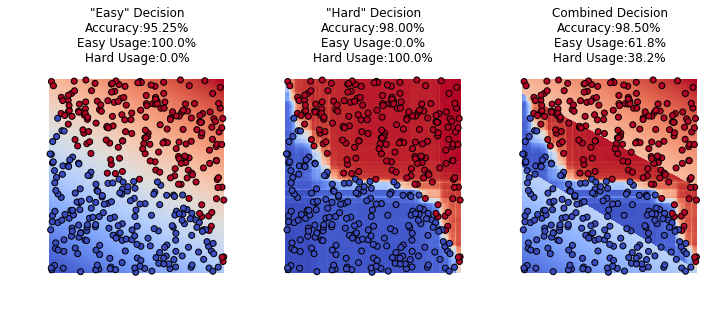

In [224]:
pylab.rcParams['figure.figsize'] = (12,4)
cmap = 'coolwarm'
textcol = 'k'

print np.max(Znorm), np.min(Znorm)

# print '==='
# print np.max(Zeasy), np.min(Zeasy)
# print np.max(Zhard), np.min(Zhard)

easy_max = np.abs(np.max(Zeasy))
easy_min = np.abs(np.min(Zeasy))
easy_mid = (np.max(Zeasy) + np.min(Zeasy)) / 2

Zeasy_prime = Zeasy.copy()
Zeasy_prime -= easy_mid
Zeasy_prime /= Zeasy_prime.max()

# ====

hard_max = np.abs(np.max(Zhard))
hard_min = np.abs(np.min(Zhard))
hard_mid = (np.max(Zhard) + np.min(Zhard)) / 2

Zhard_prime = Zhard.copy()
Zhard_prime -= hard_mid
Zhard_prime /= Zhard_prime.max()

# Zeasy_prime = Zeasy_prime / max(easy_max, easy_min)

# print '==='
# print np.max(Zeasy_prime), np.min(Zeasy_prime)
# print np.max(Zhard_prime), np.min(Zhard_prime)

# Zeasy = Zeasy / easy_max
# Zhard = Zhard / hard_max

Zcombine = Zeasy.copy()
Zcombine[Znorm == 1] = Zhard_prime[Znorm == 1]
# Zcombine[Zcombine > 0] = 1
# Zcombine[Zcombine < 0] = -1
## Normalize the individual parts for visualization
easy_max = np.abs(np.max(Zcombine[Znorm == -1]))
easy_min = np.abs(np.min(Zcombine[Znorm == -1]))
easy_mid = (easy_max + easy_min) / 2
Zcombine[Znorm == -1] -= easy_mid
Zcombine[Znorm == -1] /= easy_max

hard_max = np.abs(np.max(Zcombine[Znorm == 1]))
hard_min = np.abs(np.min(Zcombine[Znorm == 1]))
hard_mid = (hard_max + hard_min) / 2
Zcombine[Znorm == 1] -= hard_mid
Zcombine[Znorm == 1] /= hard_max

print '==='
hardness_test_y = chooser[0].predict(X_test)*chooser[1].predict(X_test)
combine_test_y = np.zeros(y_test.shape)
combine_test_y[hardness_test_y == -1] = easy.predict(X_test[hardness_test_y == -1])
combine_test_y[hardness_test_y == 1] = hard.predict(X_test[hardness_test_y == 1])
score = np.mean(combine_test_y == y_test)

print "Test score of Easy:", easy.score(testfeatures, testlabel)
print "Test score of Hard:", hard.score(testfeatures, testlabel)
print "Test score of Adaptive:", score
print "Complex utilization of Adaptive:", np.mean(hardness_test_y == 1)


fig, ax = plt.subplots(1,3)
ax[0].pcolormesh(XX, YY, Zeasy_prime, cmap=cmap, alpha=.8)
ax[0].scatter(testx, testy, c=testlabel, cmap=cmap, edgecolors='k')
# ax[0].text(XX.max() - .3, YY.min() + .3, '{:.2%}'.format(easy.score(testfeatures, testlabel)).lstrip('0'),
#                 size=15, horizontalalignment='right')
ax[0].set_axis_off()

ax[1].pcolormesh(XX, YY, Zhard_prime, cmap=cmap, alpha=.8)
ax[1].scatter(testx, testy, c=testlabel, cmap=cmap, edgecolors='k')
# ax[1].text(XX.max() - .3, YY.min() + .3, '{:.2%}'.format(hard.score(testfeatures, testlabel)).lstrip('0'),
#                 size=15, horizontalalignment='right')
ax[1].set_axis_off()

ax[2].pcolormesh(XX, YY, Zcombine, cmap=cmap, alpha=.8)
ax[2].scatter(testx, testy, c=testlabel, cmap=cmap, edgecolors='k')
# ax[2].text(XX.max() - .3, YY.min() + .3, '{:.2%}'.format(score).lstrip('0'),
#                 size=15, horizontalalignment='right')
ax[2].set_axis_off()
           
ax[0].set_title('"Easy" Decision\nAccuracy:{:.2%}\nEasy Usage:{:.1%}\nHard Usage:{:.1%}'.format(
  easy.score(testfeatures, testlabel), 
  1.0, 0.0), 
color=textcol)

ax[1].set_title ('"Hard" Decision\nAccuracy:{:.2%}\nEasy Usage:{:.1%}\nHard Usage:{:.1%}'.format(
  hard.score(testfeatures, testlabel),
  0.0,1.0), 
color = textcol)

ax[2].set_title('Combined Decision\nAccuracy:{:.2%}\nEasy Usage:{:.1%}\nHard Usage:{:.1%}'.format(
  score,
  np.mean(hardness_test_y == -1),
  np.mean(hardness_test_y == 1)
), color=textcol)

# fig, ax = plt.subplots(1,1)
# ax.pcolormesh(XX, YY, Zcombine, cmap=plt.cm.RdBu)
# ax.set_axis_off()

IndexError: index 2 is out of bounds for axis 0 with size 2

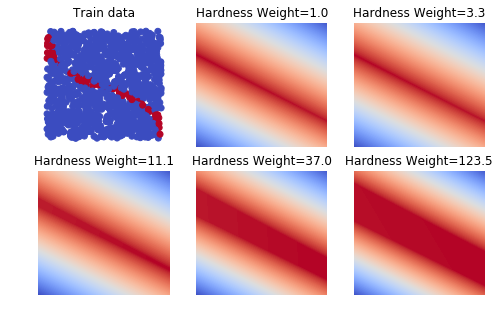

In [300]:
pylab.rcParams['figure.figsize'] = (8,5)
cmap = 'coolwarm'

from sklearn.svm import LinearSVC

plot_rows = 2
plot_cols = 3
class_weights = {-1: 1., +1: 1, 0: 1}
# Create 3 classes:
# 0: Hard
# -1: Easy -1
# +1: Easy +1
easy_train = easy.predict(X_train)
hard_train = hard.predict(X_train)
y_pseudo_auto = np.zeros(y_train.shape)
y_pseudo_auto[easy_train == y_train] = easy_train[easy_train == y_train]

fig, ax = plt.subplots(plot_rows, plot_cols)

for row in xrange(plot_cols):
  for col in xrange(plot_cols):
    if row == 0 and col == 0:
      y_scatter_pseudo = 1. - np.abs(y_pseudo_auto)
      ax[row][col].scatter(X_train[:,0], X_train[:,1], c=y_scatter_pseudo, cmap=cmap)
      ax[row][col].set_axis_off()
      ax[row][col].set_title('Train data')
    else:

      chooser_auto = LinearSVC(class_weight = class_weights)
      chooser_auto.fit(X_train, y_pseudo_auto)
      c_ravel = np.c_[XX.ravel(), YY.ravel()]

      # Zhardness = chooser_auto.decision_function(c_ravel).reshape(XX.shape+(3,))
      Zdecision = chooser_auto.decision_function(c_ravel)
      # print Zdecision.shape
      Zdecision = np.max(Zdecision, axis=1).reshape(XX.shape)
      # print Zdecision.shape

      ax[row][col].pcolormesh(XX, YY, -Zdecision, cmap=cmap)
      ax[row][col].set_axis_off()
      ax[row][col].set_title('Hardness Weight=%.1f'%class_weights[0])
      class_weights[0] *= 10./3.

In [323]:

class_weights = {-1: 1., +1: 1, 0: 1}

for _ in xrange(10):
  chooser_auto = LinearSVC(class_weight = class_weights)
  chooser_auto.fit(X_train, y_pseudo_auto)
  
  cls_to_use = chooser_auto.predict(X_test)
  # cls_to_use = 2*np.abs(cls_to_use) - 1

  y_adaptive = np.zeros(cls_to_use.shape)
  y_adaptive[cls_to_use == 1] = easy.predict(X_test[cls_to_use == 1])
  y_adaptive[cls_to_use == -1] = easy.predict(X_test[cls_to_use == -1])
  if np.sum(cls_to_use == 0) > 0:
    # print "Found zeros"
    y_adaptive[cls_to_use == 0] = hard.predict(X_test[cls_to_use == 0])

  print "Test Accuracy @ hard weight = {:.1f} : {:.2%}".format(class_weights[0], np.mean(y_adaptive == y_test))
  print "\tHard Utilization: {:.2%}".format(np.mean(cls_to_use == 0))
  class_weights[0] *= 3.
#   print np.sum(cls_to_use == 0)
#   print np.sum(cls_to_use == -1)
#   print np.sum(cls_to_use == 1)

Test Accuracy @ hard weight = 1.0 : 95.25%
	Hard Utilization: 0.00%
Test Accuracy @ hard weight = 3.0 : 95.25%
	Hard Utilization: 0.00%
Test Accuracy @ hard weight = 9.0 : 96.00%
	Hard Utilization: 1.00%
Test Accuracy @ hard weight = 27.0 : 98.00%
	Hard Utilization: 14.25%
Test Accuracy @ hard weight = 81.0 : 97.75%
	Hard Utilization: 23.25%
Test Accuracy @ hard weight = 243.0 : 98.25%
	Hard Utilization: 28.50%
Test Accuracy @ hard weight = 729.0 : 98.25%
	Hard Utilization: 31.25%
Test Accuracy @ hard weight = 2187.0 : 98.25%
	Hard Utilization: 31.75%
Test Accuracy @ hard weight = 6561.0 : 98.50%
	Hard Utilization: 32.75%
Test Accuracy @ hard weight = 19683.0 : 98.50%
	Hard Utilization: 33.00%
